In [46]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import sys
import time
from collections import namedtuple, defaultdict
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cPickle as pickle

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

import logging
from logging import info


import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
RANDOM_SEED = 10000
NN_SEED = 1234
random.seed(RANDOM_SEED)

MAX_TERMS = 10000

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
NN_PARAMETER_SEARCH_PREFIX = "nn_bow_{}_batch_{}_nn_parameter_searches.pkl"

In [7]:
root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_bow_parameter_search")

training_file = root_location + "docs_output.json"

classifications_index_file = exports_location + "classifications_index.pkl"
doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

In [8]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_label_data(classifications, doc_ids, doc_classification_map):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    data_labels = []
    for i, doc_id in enumerate(doc_ids):
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        data_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
        #if i % 1000 == 0: info(i)
    data_labels = np.array(data_labels, dtype=np.int8)
    return data_labels

In [9]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 17.7 s, sys: 1.14 s, total: 18.8 s
Wall time: 18.8 s


In [11]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 10,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 5,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [12]:
class MetricsCallbackWithGenerator(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallbackWithGenerator.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallbackWithGenerator.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallbackWithGenerator.GRAPH_MIN, MetricsCallbackWithGenerator.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict_generator(generator=nn_batch_generator(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [13]:
def nn_batch_generator_with_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(shuffle_index)
    X_data =  X_data[shuffle_index, :]
    y_data =  y_data[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0

## Training and Validation Loop

In [29]:
classifications = valid_subclasses
classifications_type = "subclasses"

In [30]:
NN_OUTPUT_NEURONS = len(classifications)
# NN_INPUT_NEURONS = DOC2VEC_SIZE

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 20
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 2048

MODEL_VERBOSITY = 1

to_skip = ['nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True']

load_existing_results = True
save_results = True


first_hidden_layer_sizes = [100,200,500,1000]
# first_hidden_layer_sizes = [1000,2000]
# second_hidden_layer_sizes = [1000,2000,3000,4000]
second_hidden_layer_sizes = [None,500,1000,2000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False, True]
# hidden_dropout_options = [False, True]
input_dropout_options = [False]
hidden_dropout_options = [True]
second_hidden_dropout_options = [False]


np.random.seed(NN_SEED)


# Uncomment for Specific Configuration
# NN_RANDOM_SEARCH_BUDGET = 1
# first_hidden_layer_sizes = [500]
# second_hidden_layer_sizes = [2000]
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False]
# hidden_dropout_options = [True]
# second_hidden_dropout_options = [False]

In [31]:
%matplotlib notebook

2017-04-07 18:56:11,551 : INFO : =============== bm25 Being Evaluated ================
2017-04-07 18:56:11,552 : INFO : Getting Training Data


CPU times: user 8min 55s, sys: 47.6 s, total: 9min 43s
Wall time: 9min 48s


2017-04-07 19:07:10,983 : INFO : Getting Validation Data


CPU times: user 1min 1s, sys: 4.31 s, total: 1min 5s
Wall time: 1min 7s
(1286325, 10000)
(1286325, 940)
CPU times: user 2min 15s, sys: 3.24 s, total: 2min 18s
Wall time: 2min 18s


2017-04-07 19:09:44,407 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_bow_parameter_search/bm25/size_10000/nn_bow_subclasses_batch_2048_nn_parameter_searches.pkl
2017-04-07 19:09:44,434 : INFO : ***************************************************************************************
2017-04-07 19:09:44,435 : INFO : nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


CPU times: user 13.5 s, sys: 576 ms, total: 14.1 s
Wall time: 13.9 s
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 100)           1000100     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_20 (Dropout)             (None, 100)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          101000      dropout_20[0][0]                 
______________________

<IPython.core.display.Javascript object>


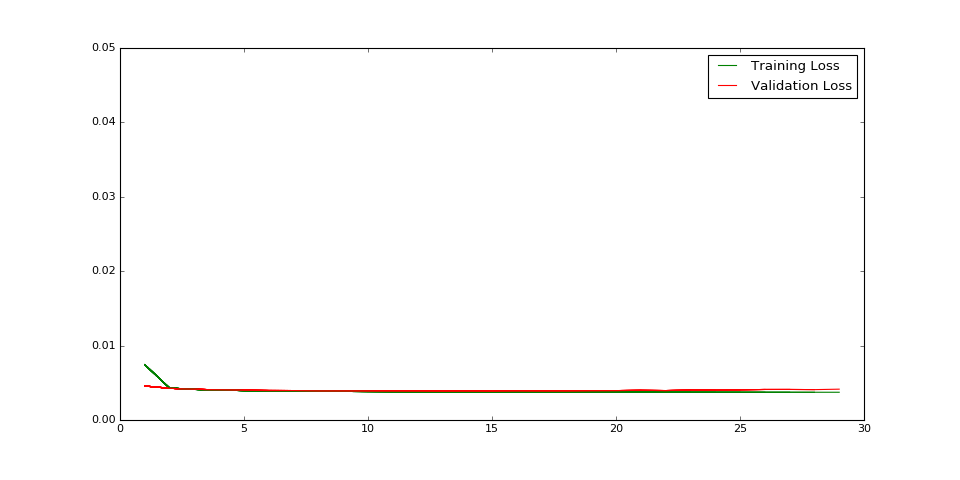

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0074

2017-04-07 19:11:16,365 : INFO : Found lower val loss for epoch 1 => 0.00457


1286325/1286325 [==============================] - 89s - loss: 0.0074 - val_loss: 0.0046
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-07 19:12:56,410 : INFO : Found lower val loss for epoch 2 => 0.00426


1286325/1286325 [==============================] - 100s - loss: 0.0043 - val_loss: 0.0043
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-07 19:14:30,015 : INFO : Found lower val loss for epoch 3 => 0.00412


1286325/1286325 [==============================] - 93s - loss: 0.0041 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-07 19:16:20,963 : INFO : Found lower val loss for epoch 4 => 0.00406


1286325/1286325 [==============================] - 110s - loss: 0.0040 - val_loss: 0.0041
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-07 19:17:51,993 : INFO : Found lower val loss for epoch 5 => 0.00399


1286325/1286325 [==============================] - 91s - loss: 0.0040 - val_loss: 0.0040
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-07 19:19:37,900 : INFO : Found lower val loss for epoch 6 => 0.00396


1286325/1286325 [==============================] - 105s - loss: 0.0039 - val_loss: 0.0040
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-07 19:21:08,015 : INFO : Found lower val loss for epoch 7 => 0.00396


1286325/1286325 [==============================] - 90s - loss: 0.0039 - val_loss: 0.0040
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-07 19:22:30,592 : INFO : Found lower val loss for epoch 8 => 0.00389


1286325/1286325 [==============================] - 82s - loss: 0.0039 - val_loss: 0.0039
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 19:23:53,784 : INFO : Found lower val loss for epoch 9 => 0.00388


1286325/1286325 [==============================] - 83s - loss: 0.0038 - val_loss: 0.0039
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 19:25:16,964 : INFO : Found lower val loss for epoch 10 => 0.00387


1286325/1286325 [==============================] - 83s - loss: 0.0038 - val_loss: 0.0039
Epoch 11/200
1286325/1286325 [==============================] - 83s - loss: 0.0038 - val_loss: 0.0039
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 19:28:02,335 : INFO : Found lower val loss for epoch 12 => 0.00387


1286325/1286325 [==============================] - 82s - loss: 0.0038 - val_loss: 0.0039
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 19:29:47,810 : INFO : Found lower val loss for epoch 13 => 0.00385


1286325/1286325 [==============================] - 105s - loss: 0.0038 - val_loss: 0.0039
Epoch 14/200
1286325/1286325 [==============================] - 142s - loss: 0.0038 - val_loss: 0.0039
Epoch 15/200
1286325/1286325 [==============================] - 100s - loss: 0.0038 - val_loss: 0.0039
Epoch 16/200
1286325/1286325 [==============================] - 145s - loss: 0.0038 - val_loss: 0.0039
Epoch 17/200
1286325/1286325 [==============================] - 107s - loss: 0.0038 - val_loss: 0.0039
Epoch 18/200
1286325/1286325 [==============================] - 117s - loss: 0.0038 - val_loss: 0.0039
Epoch 19/200
1286325/1286325 [==============================] - 83s - loss: 0.0038 - val_loss: 0.0039
Epoch 20/200
1286325/1286325 [==============================] - 84s - loss: 0.0038 - val_loss: 0.0040
Epoch 21/200
1286325/1286325 [==============================] - 134s - loss: 0.0037 - val_loss: 0.0040
Epoch 22/200
1286325/1286325 [==============================] - 121s - loss: 0.0037 - va

2017-04-07 19:59:22,350 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00028: early stopping
CPU times: user 35min 18s, sys: 39min 32s, total: 1h 14min 51s
Wall time: 49min 37s


2017-04-07 20:00:31,191 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.055 | Top 3: 0.678 | Top 5: 0.760 | F1 Micro: 0.427 | F1 Macro: 0.062


2017-04-07 20:02:37,934 : INFO : ***************************************************************************************
2017-04-07 20:02:37,943 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           1000100     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_21 (Dropout)             (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           50500       dropout_21[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


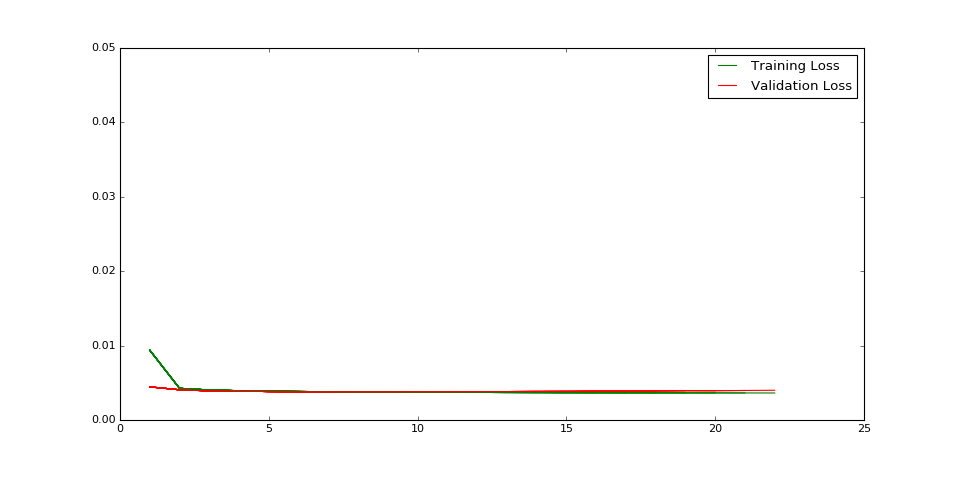

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0094

2017-04-07 20:04:15,982 : INFO : Found lower val loss for epoch 1 => 0.00445


1286325/1286325 [==============================] - 96s - loss: 0.0094 - val_loss: 0.0045
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-07 20:05:56,814 : INFO : Found lower val loss for epoch 2 => 0.00406


1286325/1286325 [==============================] - 100s - loss: 0.0043 - val_loss: 0.0041
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-07 20:07:37,046 : INFO : Found lower val loss for epoch 3 => 0.00392


1286325/1286325 [==============================] - 100s - loss: 0.0040 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-07 20:09:16,637 : INFO : Found lower val loss for epoch 4 => 0.00389


1286325/1286325 [==============================] - 99s - loss: 0.0039 - val_loss: 0.0039
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-07 20:10:45,765 : INFO : Found lower val loss for epoch 5 => 0.00382


1286325/1286325 [==============================] - 89s - loss: 0.0039 - val_loss: 0.0038
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 20:12:24,277 : INFO : Found lower val loss for epoch 6 => 0.00379


1286325/1286325 [==============================] - 98s - loss: 0.0038 - val_loss: 0.0038
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 20:14:01,294 : INFO : Found lower val loss for epoch 7 => 0.00379


1286325/1286325 [==============================] - 97s - loss: 0.0038 - val_loss: 0.0038
Epoch 8/200
1286325/1286325 [==============================] - 88s - loss: 0.0038 - val_loss: 0.0038
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 20:17:09,406 : INFO : Found lower val loss for epoch 9 => 0.00378


1286325/1286325 [==============================] - 100s - loss: 0.0038 - val_loss: 0.0038
Epoch 10/200
1286325/1286325 [==============================] - 97s - loss: 0.0037 - val_loss: 0.0038
Epoch 11/200
1286325/1286325 [==============================] - 86s - loss: 0.0037 - val_loss: 0.0038
Epoch 12/200
1286325/1286325 [==============================] - 96s - loss: 0.0037 - val_loss: 0.0038
Epoch 13/200
1286325/1286325 [==============================] - 100s - loss: 0.0037 - val_loss: 0.0038
Epoch 14/200
1286325/1286325 [==============================] - 102s - loss: 0.0037 - val_loss: 0.0038
Epoch 15/200
1286325/1286325 [==============================] - 119s - loss: 0.0037 - val_loss: 0.0038
Epoch 16/200
1286325/1286325 [==============================] - 100s - loss: 0.0037 - val_loss: 0.0039
Epoch 17/200
1286325/1286325 [==============================] - 123s - loss: 0.0037 - val_loss: 0.0039
Epoch 18/200
1286325/1286325 [==============================] - 97s - loss: 0.0037 - val_

2017-04-07 20:39:18,642 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00021: early stopping
CPU times: user 27min 41s, sys: 28min 45s, total: 56min 27s
Wall time: 36min 40s


2017-04-07 20:40:42,280 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.348 | Top 3: 0.694 | Top 5: 0.777 | F1 Micro: 0.510 | F1 Macro: 0.100


2017-04-07 20:43:03,687 : INFO : ***************************************************************************************
2017-04-07 20:43:03,689 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           2000200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_22 (Dropout)             (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          402000      dropout_22[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


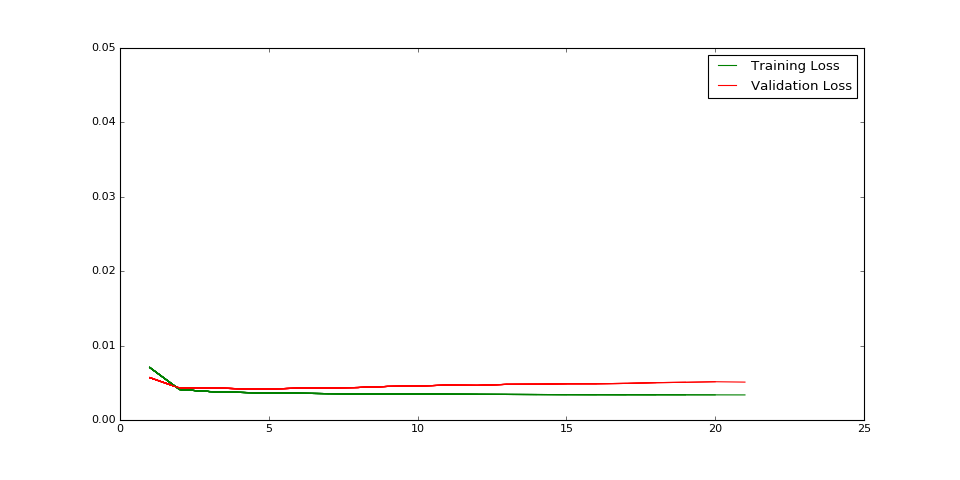

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0071

2017-04-07 20:44:35,301 : INFO : Found lower val loss for epoch 1 => 0.00569


1286325/1286325 [==============================] - 89s - loss: 0.0071 - val_loss: 0.0057
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-07 20:46:00,082 : INFO : Found lower val loss for epoch 2 => 0.0043


1286325/1286325 [==============================] - 84s - loss: 0.0041 - val_loss: 0.0043
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 20:47:25,929 : INFO : Found lower val loss for epoch 3 => 0.00429


1286325/1286325 [==============================] - 85s - loss: 0.0038 - val_loss: 0.0043
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-07 20:48:51,713 : INFO : Found lower val loss for epoch 4 => 0.00421


1286325/1286325 [==============================] - 85s - loss: 0.0037 - val_loss: 0.0042
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-07 20:50:16,255 : INFO : Found lower val loss for epoch 5 => 0.00418


1286325/1286325 [==============================] - 84s - loss: 0.0036 - val_loss: 0.0042
Epoch 6/200
1286325/1286325 [==============================] - 90s - loss: 0.0036 - val_loss: 0.0043
Epoch 7/200
1286325/1286325 [==============================] - 85s - loss: 0.0035 - val_loss: 0.0043
Epoch 8/200
1286325/1286325 [==============================] - 84s - loss: 0.0035 - val_loss: 0.0044
Epoch 9/200
1286325/1286325 [==============================] - 85s - loss: 0.0035 - val_loss: 0.0045
Epoch 10/200
1286325/1286325 [==============================] - 86s - loss: 0.0035 - val_loss: 0.0046
Epoch 11/200
1286325/1286325 [==============================] - 83s - loss: 0.0035 - val_loss: 0.0047
Epoch 12/200
1286325/1286325 [==============================] - 85s - loss: 0.0034 - val_loss: 0.0047
Epoch 13/200
1286325/1286325 [==============================] - 85s - loss: 0.0034 - val_loss: 0.0048
Epoch 14/200
1286325/1286325 [==============================] - 86s - loss: 0.0034 - val_loss: 0.00

2017-04-07 21:13:00,179 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00020: early stopping
CPU times: user 25min 39s, sys: 23min 33s, total: 49min 13s
Wall time: 29min 56s


2017-04-07 21:14:04,849 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.431 | Top 3: 0.681 | Top 5: 0.764 | F1 Micro: 0.429 | F1 Macro: 0.067


2017-04-07 21:16:12,982 : INFO : ***************************************************************************************
2017-04-07 21:16:12,985 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_23 (Dropout)             (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_23[0][0]                 
Total params: 10941940
____________________________________________________________________

<IPython.core.display.Javascript object>


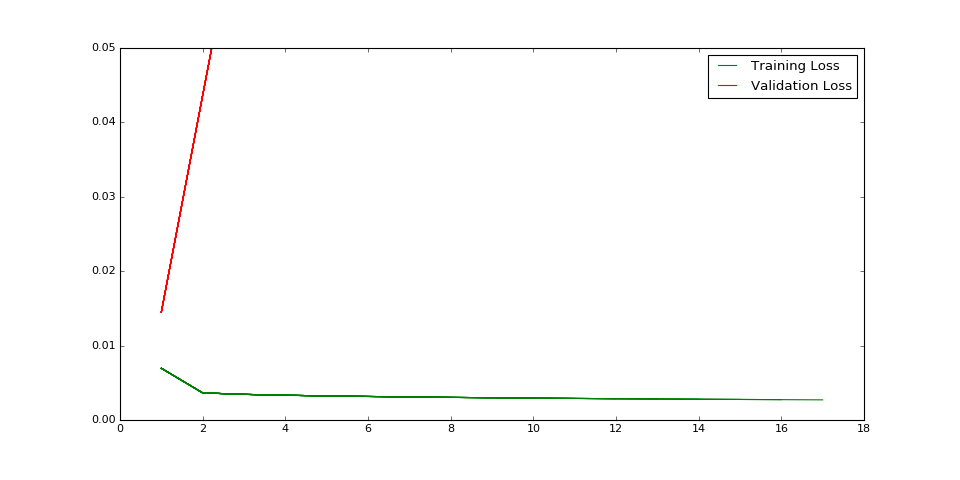

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0070

2017-04-07 21:17:45,092 : INFO : Found lower val loss for epoch 1 => 0.01451


1286325/1286325 [==============================] - 90s - loss: 0.0070 - val_loss: 0.0145
Epoch 2/200
1286325/1286325 [==============================] - 103s - loss: 0.0036 - val_loss: 0.0436
Epoch 3/200
1286325/1286325 [==============================] - 92s - loss: 0.0034 - val_loss: 0.0727
Epoch 4/200
1286325/1286325 [==============================] - 86s - loss: 0.0033 - val_loss: 0.0975
Epoch 5/200
1286325/1286325 [==============================] - 85s - loss: 0.0032 - val_loss: 0.1173
Epoch 6/200
1286325/1286325 [==============================] - 86s - loss: 0.0032 - val_loss: 0.1325
Epoch 7/200
1286325/1286325 [==============================] - 85s - loss: 0.0031 - val_loss: 0.1443
Epoch 8/200
1286325/1286325 [==============================] - 87s - loss: 0.0030 - val_loss: 0.1469
Epoch 9/200
1286325/1286325 [==============================] - 87s - loss: 0.0030 - val_loss: 0.1514
Epoch 10/200
1286325/1286325 [==============================] - 86s - loss: 0.0029 - val_loss: 0.1477


2017-04-07 21:41:53,876 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00016: early stopping
CPU times: user 21min 11s, sys: 21min 37s, total: 42min 48s
Wall time: 25min 40s


2017-04-07 21:43:34,535 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.961 | Top 3: 0.692 | Top 5: 0.776 | F1 Micro: 0.470 | F1 Macro: 0.125


2017-04-07 21:46:01,432 : INFO : ***************************************************************************************
2017-04-07 21:46:01,443 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           2000200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_24 (Dropout)             (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 500)           100500      dropout_24[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


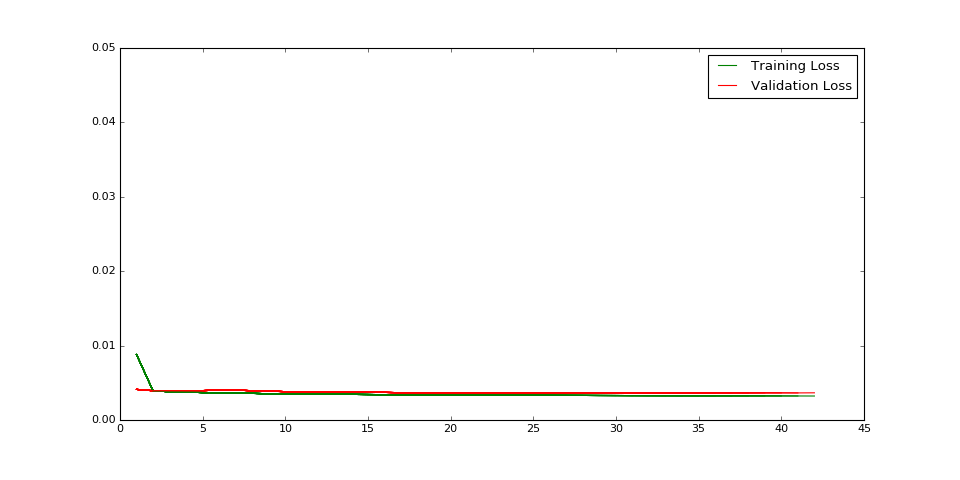

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0088

2017-04-07 21:51:01,033 : INFO : Found lower val loss for epoch 1 => 0.00411


1286325/1286325 [==============================] - 297s - loss: 0.0088 - val_loss: 0.0041
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-07 21:55:09,495 : INFO : Found lower val loss for epoch 2 => 0.00393


1286325/1286325 [==============================] - 248s - loss: 0.0039 - val_loss: 0.0039
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-07 21:57:29,981 : INFO : Found lower val loss for epoch 3 => 0.00392


1286325/1286325 [==============================] - 140s - loss: 0.0038 - val_loss: 0.0039
Epoch 4/200
1286325/1286325 [==============================] - 94s - loss: 0.0037 - val_loss: 0.0039
Epoch 5/200
1286325/1286325 [==============================] - 100s - loss: 0.0037 - val_loss: 0.0040
Epoch 6/200
1286325/1286325 [==============================] - 134s - loss: 0.0037 - val_loss: 0.0040
Epoch 7/200
1286325/1286325 [==============================] - 96s - loss: 0.0036 - val_loss: 0.0040
Epoch 8/200
1286325/1286325 [==============================] - 108s - loss: 0.0036 - val_loss: 0.0039
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-07 22:07:53,328 : INFO : Found lower val loss for epoch 9 => 0.00387


1286325/1286325 [==============================] - 87s - loss: 0.0035 - val_loss: 0.0039
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-07 22:09:28,586 : INFO : Found lower val loss for epoch 10 => 0.00381


1286325/1286325 [==============================] - 95s - loss: 0.0035 - val_loss: 0.0038
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-07 22:11:10,019 : INFO : Found lower val loss for epoch 11 => 0.00379


1286325/1286325 [==============================] - 101s - loss: 0.0035 - val_loss: 0.0038
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-07 22:12:52,265 : INFO : Found lower val loss for epoch 12 => 0.00375


1286325/1286325 [==============================] - 102s - loss: 0.0035 - val_loss: 0.0037
Epoch 13/200
1286325/1286325 [==============================] - 108s - loss: 0.0035 - val_loss: 0.0038
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 22:17:17,501 : INFO : Found lower val loss for epoch 14 => 0.00371


1286325/1286325 [==============================] - 156s - loss: 0.0034 - val_loss: 0.0037
Epoch 15/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 22:19:17,558 : INFO : Found lower val loss for epoch 15 => 0.00371


1286325/1286325 [==============================] - 120s - loss: 0.0034 - val_loss: 0.0037
Epoch 16/200
1286325/1286325 [==============================] - 153s - loss: 0.0034 - val_loss: 0.0037
Epoch 17/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 22:24:33,277 : INFO : Found lower val loss for epoch 17 => 0.00367


1286325/1286325 [==============================] - 161s - loss: 0.0034 - val_loss: 0.0037
Epoch 18/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 22:26:35,189 : INFO : Found lower val loss for epoch 18 => 0.00367


1286325/1286325 [==============================] - 121s - loss: 0.0034 - val_loss: 0.0037
Epoch 19/200
1286325/1286325 [==============================] - 156s - loss: 0.0034 - val_loss: 0.0037
Epoch 20/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 22:31:28,361 : INFO : Found lower val loss for epoch 20 => 0.00366


1286325/1286325 [==============================] - 136s - loss: 0.0034 - val_loss: 0.0037
Epoch 21/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 22:33:00,659 : INFO : Found lower val loss for epoch 21 => 0.00365


1286325/1286325 [==============================] - 92s - loss: 0.0034 - val_loss: 0.0036
Epoch 22/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-07 22:35:17,704 : INFO : Found lower val loss for epoch 22 => 0.00364


1286325/1286325 [==============================] - 137s - loss: 0.0033 - val_loss: 0.0036
Epoch 23/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-07 22:36:45,703 : INFO : Found lower val loss for epoch 23 => 0.00364


1286325/1286325 [==============================] - 87s - loss: 0.0033 - val_loss: 0.0036
Epoch 24/200
1286325/1286325 [==============================] - 134s - loss: 0.0033 - val_loss: 0.0037
Epoch 25/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-07 22:40:42,233 : INFO : Found lower val loss for epoch 25 => 0.00363


1286325/1286325 [==============================] - 101s - loss: 0.0033 - val_loss: 0.0036
Epoch 26/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-07 22:42:43,271 : INFO : Found lower val loss for epoch 26 => 0.00363


1286325/1286325 [==============================] - 121s - loss: 0.0033 - val_loss: 0.0036
Epoch 27/200
1286325/1286325 [==============================] - 132s - loss: 0.0033 - val_loss: 0.0036
Epoch 28/200
1286325/1286325 [==============================] - 118s - loss: 0.0033 - val_loss: 0.0037
Epoch 29/200
1286325/1286325 [==============================] - 150s - loss: 0.0033 - val_loss: 0.0037
Epoch 30/200
1286325/1286325 [==============================] - 111s - loss: 0.0033 - val_loss: 0.0036
Epoch 31/200
1286325/1286325 [==============================] - 83s - loss: 0.0033 - val_loss: 0.0036
Epoch 32/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-07 22:54:10,868 : INFO : Found lower val loss for epoch 32 => 0.00362


1286325/1286325 [==============================] - 89s - loss: 0.0033 - val_loss: 0.0036
Epoch 33/200
1286325/1286325 [==============================] - 127s - loss: 0.0033 - val_loss: 0.0036
Epoch 34/200
1286325/1286325 [==============================] - 94s - loss: 0.0033 - val_loss: 0.0036
Epoch 35/200
1286325/1286325 [==============================] - 93s - loss: 0.0033 - val_loss: 0.0036
Epoch 36/200
1286325/1286325 [==============================] - 86s - loss: 0.0033 - val_loss: 0.0036
Epoch 37/200
1286325/1286325 [==============================] - 83s - loss: 0.0032 - val_loss: 0.0036
Epoch 38/200
1286325/1286325 [==============================] - 88s - loss: 0.0032 - val_loss: 0.0036
Epoch 39/200
1286325/1286325 [==============================] - 102s - loss: 0.0032 - val_loss: 0.0036
Epoch 40/200
1286325/1286325 [==============================] - 122s - loss: 0.0032 - val_loss: 0.0036
Epoch 41/200
1286325/1286325 [==============================] - 102s - loss: 0.0032 - val_lo

2017-04-07 23:11:03,255 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00041: early stopping
CPU times: user 51min 15s, sys: 1h 13min 45s, total: 2h 5min 1s
Wall time: 1h 25min 1s


2017-04-07 23:13:28,834 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.954 | Top 3: 0.709 | Top 5: 0.790 | F1 Micro: 0.511 | F1 Macro: 0.113


2017-04-07 23:15:58,032 : INFO : ***************************************************************************************
2017-04-07 23:15:58,035 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_25[0][0]                 
Total params: 10941940
____________________________________________________________________

<IPython.core.display.Javascript object>


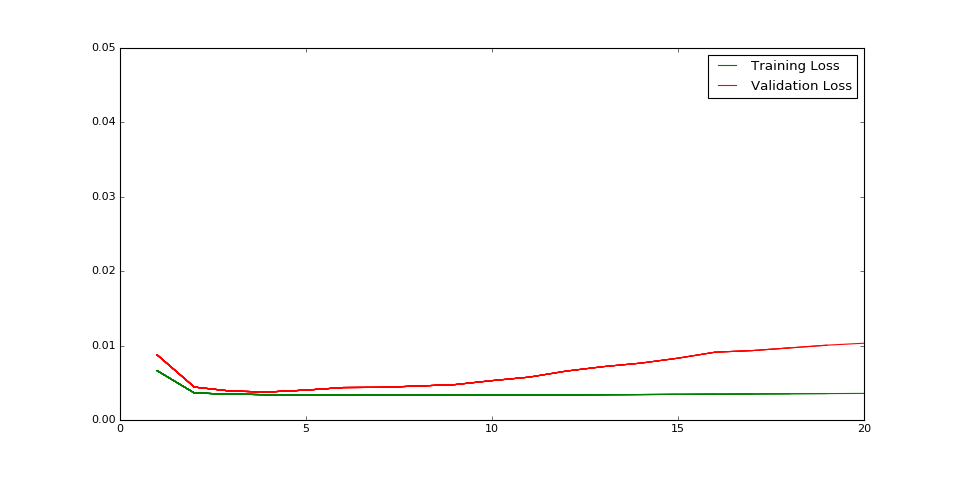

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0066

2017-04-07 23:19:13,707 : INFO : Found lower val loss for epoch 1 => 0.00875


1286325/1286325 [==============================] - 194s - loss: 0.0066 - val_loss: 0.0087
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-07 23:20:55,137 : INFO : Found lower val loss for epoch 2 => 0.00442


1286325/1286325 [==============================] - 101s - loss: 0.0036 - val_loss: 0.0044
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-07 23:22:27,111 : INFO : Found lower val loss for epoch 3 => 0.00387


1286325/1286325 [==============================] - 91s - loss: 0.0035 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-07 23:24:01,795 : INFO : Found lower val loss for epoch 4 => 0.00377


1286325/1286325 [==============================] - 94s - loss: 0.0034 - val_loss: 0.0038
Epoch 5/200
1286325/1286325 [==============================] - 92s - loss: 0.0034 - val_loss: 0.0040
Epoch 6/200
1286325/1286325 [==============================] - 99s - loss: 0.0033 - val_loss: 0.0044
Epoch 7/200
1286325/1286325 [==============================] - 95s - loss: 0.0033 - val_loss: 0.0044
Epoch 8/200
1286325/1286325 [==============================] - 98s - loss: 0.0033 - val_loss: 0.0046
Epoch 9/200
1286325/1286325 [==============================] - 97s - loss: 0.0033 - val_loss: 0.0048
Epoch 10/200
1286325/1286325 [==============================] - 106s - loss: 0.0033 - val_loss: 0.0053
Epoch 11/200
1286325/1286325 [==============================] - 99s - loss: 0.0034 - val_loss: 0.0058
Epoch 12/200
1286325/1286325 [==============================] - 98s - loss: 0.0034 - val_loss: 0.0066
Epoch 13/200
1286325/1286325 [==============================] - 107s - loss: 0.0034 - val_loss: 0.0

2017-04-07 23:50:28,905 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00019: early stopping
CPU times: user 26min 56s, sys: 29min 41s, total: 56min 37s
Wall time: 34min 30s


2017-04-07 23:51:39,619 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.777 | Top 3: 0.722 | Top 5: 0.802 | F1 Micro: 0.446 | F1 Macro: 0.103


2017-04-07 23:53:48,989 : INFO : ***************************************************************************************
2017-04-07 23:53:48,996 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           2000200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_26 (Dropout)             (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          402000      dropout_26[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


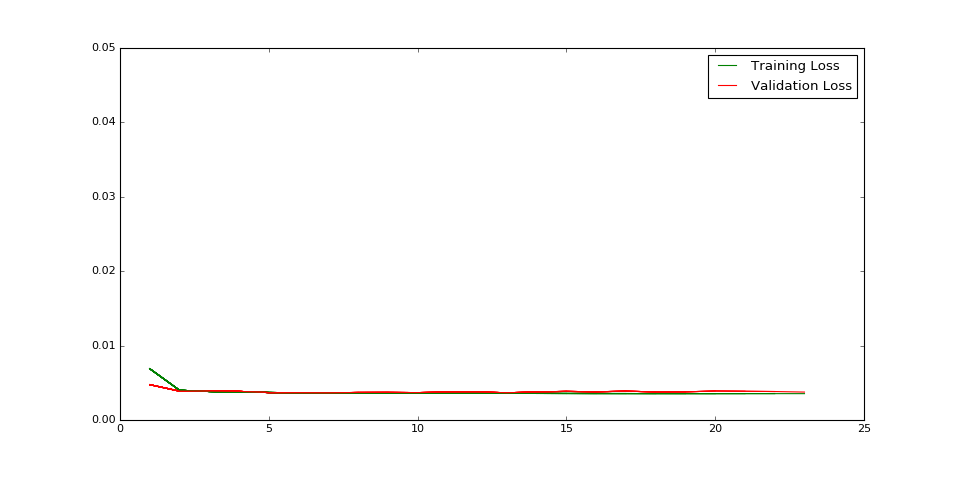

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0069

2017-04-07 23:55:36,871 : INFO : Found lower val loss for epoch 1 => 0.00475


1286325/1286325 [==============================] - 105s - loss: 0.0069 - val_loss: 0.0048
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-07 23:57:20,406 : INFO : Found lower val loss for epoch 2 => 0.00388


1286325/1286325 [==============================] - 103s - loss: 0.0040 - val_loss: 0.0039
Epoch 3/200
1286325/1286325 [==============================] - 93s - loss: 0.0038 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-08 00:00:32,377 : INFO : Found lower val loss for epoch 4 => 0.00385


1286325/1286325 [==============================] - 98s - loss: 0.0037 - val_loss: 0.0038
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-08 00:02:11,362 : INFO : Found lower val loss for epoch 5 => 0.00369


1286325/1286325 [==============================] - 98s - loss: 0.0037 - val_loss: 0.0037
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-08 00:03:59,923 : INFO : Found lower val loss for epoch 6 => 0.00368


1286325/1286325 [==============================] - 108s - loss: 0.0037 - val_loss: 0.0037
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-08 00:05:34,274 : INFO : Found lower val loss for epoch 7 => 0.00366


1286325/1286325 [==============================] - 94s - loss: 0.0036 - val_loss: 0.0037
Epoch 8/200
1286325/1286325 [==============================] - 130s - loss: 0.0036 - val_loss: 0.0037
Epoch 9/200
1286325/1286325 [==============================] - 103s - loss: 0.0036 - val_loss: 0.0037
Epoch 10/200
1286325/1286325 [==============================] - 89s - loss: 0.0036 - val_loss: 0.0037
Epoch 11/200
1286325/1286325 [==============================] - 93s - loss: 0.0036 - val_loss: 0.0037
Epoch 12/200
1286325/1286325 [==============================] - 95s - loss: 0.0036 - val_loss: 0.0038
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-08 00:15:37,163 : INFO : Found lower val loss for epoch 13 => 0.00366


1286325/1286325 [==============================] - 90s - loss: 0.0036 - val_loss: 0.0037
Epoch 14/200
1286325/1286325 [==============================] - 93s - loss: 0.0036 - val_loss: 0.0038
Epoch 15/200
1286325/1286325 [==============================] - 104s - loss: 0.0036 - val_loss: 0.0038
Epoch 16/200
1286325/1286325 [==============================] - 113s - loss: 0.0036 - val_loss: 0.0038
Epoch 17/200
1286325/1286325 [==============================] - 102s - loss: 0.0036 - val_loss: 0.0039
Epoch 18/200
1286325/1286325 [==============================] - 104s - loss: 0.0036 - val_loss: 0.0038
Epoch 19/200
1286325/1286325 [==============================] - 101s - loss: 0.0035 - val_loss: 0.0038
Epoch 20/200
1286325/1286325 [==============================] - 101s - loss: 0.0035 - val_loss: 0.0039
Epoch 21/200
1286325/1286325 [==============================] - 111s - loss: 0.0035 - val_loss: 0.0039
Epoch 22/200
1286325/1286325 [==============================] - 97s - loss: 0.0035 - val

2017-04-08 00:33:02,478 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00022: early stopping
CPU times: user 30min 3s, sys: 33min 21s, total: 1h 3min 24s
Wall time: 39min 13s


2017-04-08 00:34:19,781 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.621 | Top 3: 0.710 | Top 5: 0.790 | F1 Micro: 0.513 | F1 Macro: 0.107


2017-04-08 00:36:32,125 : INFO : ***************************************************************************************
2017-04-08 00:36:32,132 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           1000100     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_27 (Dropout)             (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 1000)          101000      dropout_27[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


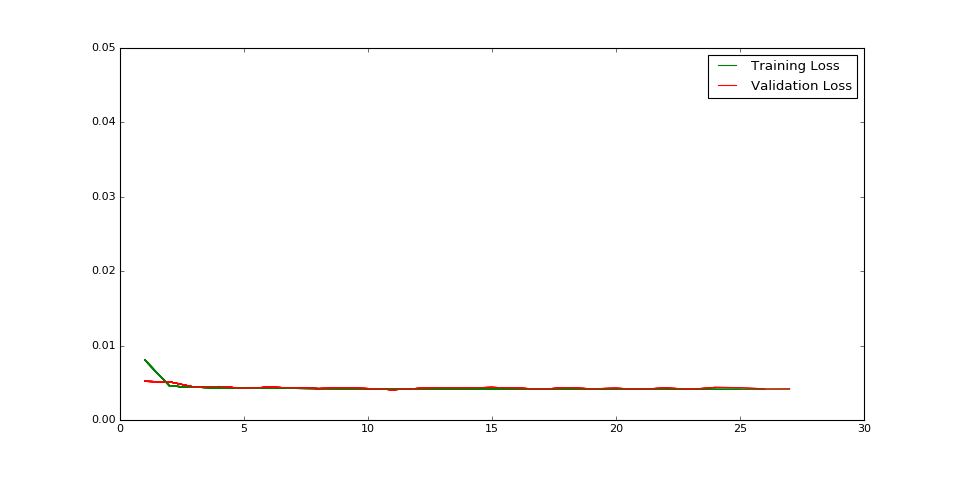

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0081

2017-04-08 00:38:37,387 : INFO : Found lower val loss for epoch 1 => 0.00519


1286325/1286325 [==============================] - 123s - loss: 0.0081 - val_loss: 0.0052
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0046

2017-04-08 00:40:31,502 : INFO : Found lower val loss for epoch 2 => 0.00513


1286325/1286325 [==============================] - 114s - loss: 0.0046 - val_loss: 0.0051
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0044

2017-04-08 00:43:04,987 : INFO : Found lower val loss for epoch 3 => 0.00442


1286325/1286325 [==============================] - 153s - loss: 0.0044 - val_loss: 0.0044
Epoch 4/200
1286325/1286325 [==============================] - 141s - loss: 0.0043 - val_loss: 0.0045
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-08 00:47:21,129 : INFO : Found lower val loss for epoch 5 => 0.00426


1286325/1286325 [==============================] - 115s - loss: 0.0043 - val_loss: 0.0043
Epoch 6/200
1286325/1286325 [==============================] - 129s - loss: 0.0043 - val_loss: 0.0044
Epoch 7/200
1286325/1286325 [==============================] - 114s - loss: 0.0042 - val_loss: 0.0043
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-08 00:53:09,021 : INFO : Found lower val loss for epoch 8 => 0.00423


1286325/1286325 [==============================] - 103s - loss: 0.0042 - val_loss: 0.0042
Epoch 9/200
1286325/1286325 [==============================] - 106s - loss: 0.0042 - val_loss: 0.0043
Epoch 10/200
1286325/1286325 [==============================] - 96s - loss: 0.0042 - val_loss: 0.0042
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-08 00:58:03,574 : INFO : Found lower val loss for epoch 11 => 0.00407


1286325/1286325 [==============================] - 91s - loss: 0.0042 - val_loss: 0.0041
Epoch 12/200
1286325/1286325 [==============================] - 101s - loss: 0.0042 - val_loss: 0.0042
Epoch 13/200
1286325/1286325 [==============================] - 108s - loss: 0.0042 - val_loss: 0.0043
Epoch 14/200
1286325/1286325 [==============================] - 97s - loss: 0.0042 - val_loss: 0.0043
Epoch 15/200
1286325/1286325 [==============================] - 107s - loss: 0.0042 - val_loss: 0.0044
Epoch 16/200
1286325/1286325 [==============================] - 98s - loss: 0.0042 - val_loss: 0.0043
Epoch 17/200
1286325/1286325 [==============================] - 94s - loss: 0.0042 - val_loss: 0.0041
Epoch 18/200
1286325/1286325 [==============================] - 97s - loss: 0.0042 - val_loss: 0.0043
Epoch 19/200
1286325/1286325 [==============================] - 102s - loss: 0.0042 - val_loss: 0.0042
Epoch 20/200
1286325/1286325 [==============================] - 102s - loss: 0.0042 - val_l

2017-04-08 01:28:15,493 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00026: early stopping
CPU times: user 35min 15s, sys: 44min 30s, total: 1h 19min 46s
Wall time: 51min 42s


2017-04-08 01:30:23,626 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.953 | Top 3: 0.665 | Top 5: 0.747 | F1 Micro: 0.478 | F1 Macro: 0.064


2017-04-08 01:32:49,481 : INFO : ***************************************************************************************
2017-04-08 01:32:49,496 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           5000500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_28 (Dropout)             (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          1002000     dropout_28[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


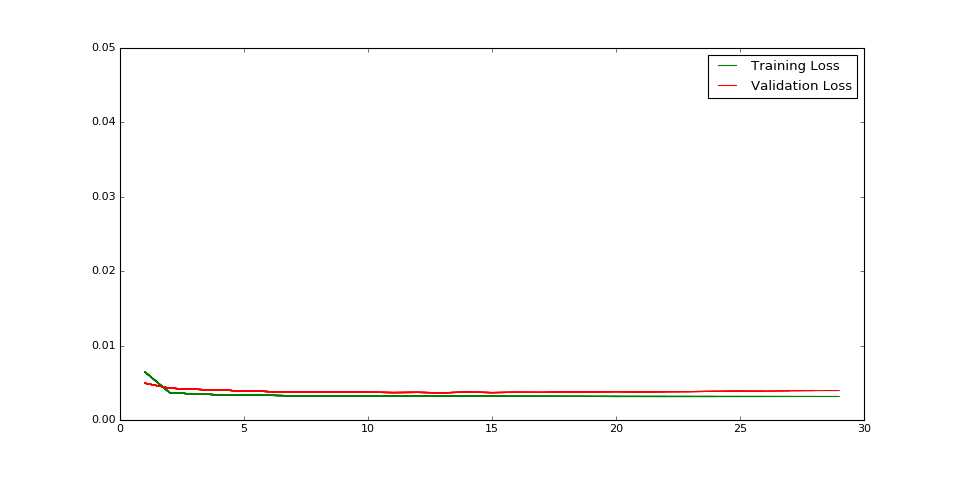

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0065

2017-04-08 01:34:50,588 : INFO : Found lower val loss for epoch 1 => 0.00495


1286325/1286325 [==============================] - 119s - loss: 0.0065 - val_loss: 0.0049
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-08 01:36:30,278 : INFO : Found lower val loss for epoch 2 => 0.00427


1286325/1286325 [==============================] - 99s - loss: 0.0037 - val_loss: 0.0043
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-08 01:38:28,052 : INFO : Found lower val loss for epoch 3 => 0.00412


1286325/1286325 [==============================] - 117s - loss: 0.0035 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-08 01:40:13,640 : INFO : Found lower val loss for epoch 4 => 0.00403


1286325/1286325 [==============================] - 105s - loss: 0.0034 - val_loss: 0.0040
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 01:42:01,418 : INFO : Found lower val loss for epoch 5 => 0.0039


1286325/1286325 [==============================] - 107s - loss: 0.0033 - val_loss: 0.0039
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 01:44:18,105 : INFO : Found lower val loss for epoch 6 => 0.00382


1286325/1286325 [==============================] - 136s - loss: 0.0033 - val_loss: 0.0038
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 01:46:08,864 : INFO : Found lower val loss for epoch 7 => 0.00377


1286325/1286325 [==============================] - 110s - loss: 0.0033 - val_loss: 0.0038
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 01:48:02,378 : INFO : Found lower val loss for epoch 8 => 0.00375


1286325/1286325 [==============================] - 113s - loss: 0.0033 - val_loss: 0.0037
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 01:49:54,983 : INFO : Found lower val loss for epoch 9 => 0.00372


1286325/1286325 [==============================] - 112s - loss: 0.0032 - val_loss: 0.0037
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 01:51:32,506 : INFO : Found lower val loss for epoch 10 => 0.00372


1286325/1286325 [==============================] - 97s - loss: 0.0032 - val_loss: 0.0037
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 01:53:53,040 : INFO : Found lower val loss for epoch 11 => 0.00369


1286325/1286325 [==============================] - 140s - loss: 0.0032 - val_loss: 0.0037
Epoch 12/200
1286325/1286325 [==============================] - 91s - loss: 0.0032 - val_loss: 0.0037
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 01:57:00,168 : INFO : Found lower val loss for epoch 13 => 0.00367


1286325/1286325 [==============================] - 95s - loss: 0.0032 - val_loss: 0.0037
Epoch 14/200
1286325/1286325 [==============================] - 99s - loss: 0.0032 - val_loss: 0.0037
Epoch 15/200
1286325/1286325 [==============================] - 104s - loss: 0.0032 - val_loss: 0.0037
Epoch 16/200
1286325/1286325 [==============================] - 91s - loss: 0.0032 - val_loss: 0.0037
Epoch 17/200
1286325/1286325 [==============================] - 120s - loss: 0.0032 - val_loss: 0.0037
Epoch 18/200
1286325/1286325 [==============================] - 135s - loss: 0.0032 - val_loss: 0.0038
Epoch 19/200
1286325/1286325 [==============================] - 131s - loss: 0.0032 - val_loss: 0.0038
Epoch 20/200
1286325/1286325 [==============================] - 166s - loss: 0.0032 - val_loss: 0.0038
Epoch 21/200
1286325/1286325 [==============================] - 146s - loss: 0.0032 - val_loss: 0.0038
Epoch 22/200
1286325/1286325 [==============================] - 150s - loss: 0.0032 - val

2017-04-08 02:31:02,459 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00028: early stopping
CPU times: user 38min 16s, sys: 52min 53s, total: 1h 31min 10s
Wall time: 58min 12s


2017-04-08 02:32:40,852 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.231 | Top 3: 0.723 | Top 5: 0.803 | F1 Micro: 0.538 | F1 Macro: 0.144


2017-04-08 02:35:08,363 : INFO : ***************************************************************************************
2017-04-08 02:35:08,366 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_29 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 2000)          2002000     dropout_29[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


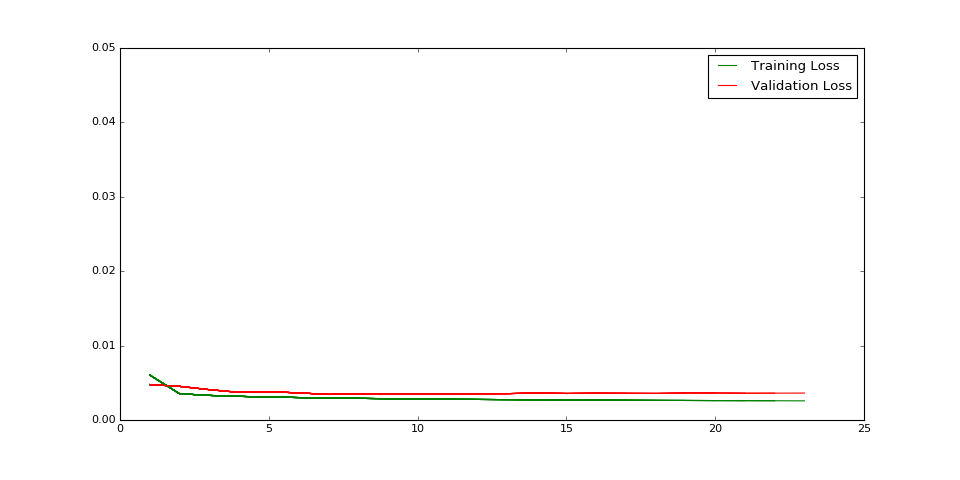

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0060

2017-04-08 02:40:26,025 : INFO : Found lower val loss for epoch 1 => 0.00476


1286325/1286325 [==============================] - 310s - loss: 0.0060 - val_loss: 0.0048
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-08 02:44:15,589 : INFO : Found lower val loss for epoch 2 => 0.00452


1286325/1286325 [==============================] - 229s - loss: 0.0035 - val_loss: 0.0045
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 02:46:58,973 : INFO : Found lower val loss for epoch 3 => 0.00408


1286325/1286325 [==============================] - 163s - loss: 0.0033 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 02:49:56,830 : INFO : Found lower val loss for epoch 4 => 0.00371


1286325/1286325 [==============================] - 177s - loss: 0.0032 - val_loss: 0.0037
Epoch 5/200
1286325/1286325 [==============================] - 214s - loss: 0.0031 - val_loss: 0.0038
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0030

2017-04-08 02:57:30,973 : INFO : Found lower val loss for epoch 6 => 0.00365


1286325/1286325 [==============================] - 239s - loss: 0.0030 - val_loss: 0.0036
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0030

2017-04-08 03:01:33,478 : INFO : Found lower val loss for epoch 7 => 0.00344


1286325/1286325 [==============================] - 242s - loss: 0.0030 - val_loss: 0.0034
Epoch 8/200
1286325/1286325 [==============================] - 154s - loss: 0.0029 - val_loss: 0.0035
Epoch 9/200
1286325/1286325 [==============================] - 150s - loss: 0.0029 - val_loss: 0.0035
Epoch 10/200
1286325/1286325 [==============================] - 201s - loss: 0.0028 - val_loss: 0.0035
Epoch 11/200
1286325/1286325 [==============================] - 212s - loss: 0.0028 - val_loss: 0.0035
Epoch 12/200
1286325/1286325 [==============================] - 190s - loss: 0.0028 - val_loss: 0.0035
Epoch 13/200
1286325/1286325 [==============================] - 106s - loss: 0.0027 - val_loss: 0.0035
Epoch 14/200
1286325/1286325 [==============================] - 139s - loss: 0.0027 - val_loss: 0.0036
Epoch 15/200
1286325/1286325 [==============================] - 112s - loss: 0.0027 - val_loss: 0.0036
Epoch 16/200
1286325/1286325 [==============================] - 106s - loss: 0.0027 - va

2017-04-08 03:41:06,130 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00022: early stopping
CPU times: user 31min 12s, sys: 1h 3min 29s, total: 1h 34min 42s
Wall time: 1h 5min 54s


2017-04-08 03:43:04,029 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 7.162 | Top 3: 0.741 | Top 5: 0.819 | F1 Micro: 0.553 | F1 Macro: 0.176


2017-04-08 03:45:28,853 : INFO : ***************************************************************************************
2017-04-08 03:45:28,859 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           2000200     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_30 (Dropout)             (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          201000      dropout_30[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


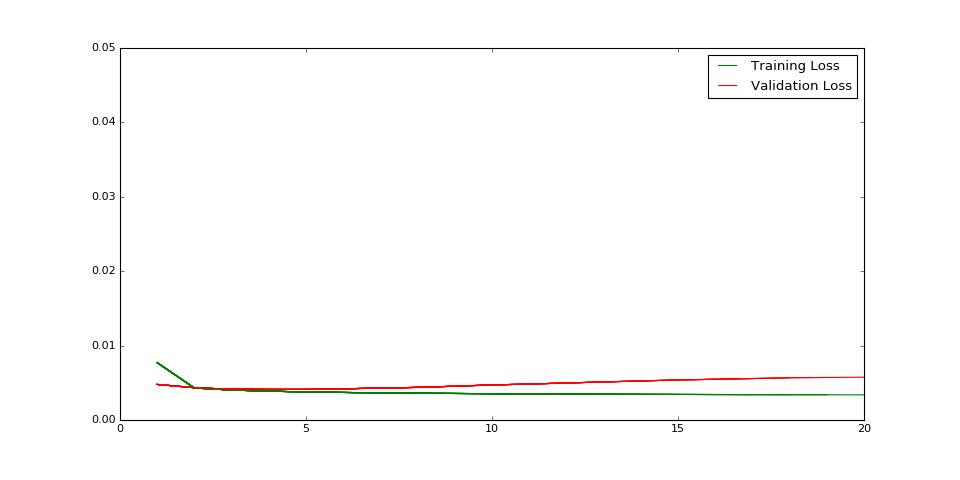

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0077

2017-04-08 03:48:54,756 : INFO : Found lower val loss for epoch 1 => 0.00478


1286325/1286325 [==============================] - 89s - loss: 0.0077 - val_loss: 0.0048
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-08 03:50:20,376 : INFO : Found lower val loss for epoch 2 => 0.00434


1286325/1286325 [==============================] - 85s - loss: 0.0043 - val_loss: 0.0043
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-08 03:51:47,044 : INFO : Found lower val loss for epoch 3 => 0.00413


1286325/1286325 [==============================] - 86s - loss: 0.0040 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-08 03:53:14,720 : INFO : Found lower val loss for epoch 4 => 0.00411


1286325/1286325 [==============================] - 87s - loss: 0.0039 - val_loss: 0.0041
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-08 03:54:40,538 : INFO : Found lower val loss for epoch 5 => 0.00411


1286325/1286325 [==============================] - 85s - loss: 0.0038 - val_loss: 0.0041
Epoch 6/200
1286325/1286325 [==============================] - 86s - loss: 0.0037 - val_loss: 0.0042
Epoch 7/200
1286325/1286325 [==============================] - 87s - loss: 0.0036 - val_loss: 0.0043
Epoch 8/200
1286325/1286325 [==============================] - 84s - loss: 0.0036 - val_loss: 0.0044
Epoch 9/200
1286325/1286325 [==============================] - 87s - loss: 0.0036 - val_loss: 0.0045
Epoch 10/200
1286325/1286325 [==============================] - 86s - loss: 0.0035 - val_loss: 0.0047
Epoch 11/200
1286325/1286325 [==============================] - 84s - loss: 0.0035 - val_loss: 0.0048
Epoch 12/200
1286325/1286325 [==============================] - 85s - loss: 0.0035 - val_loss: 0.0050
Epoch 13/200
1286325/1286325 [==============================] - 83s - loss: 0.0035 - val_loss: 0.0051
Epoch 14/200
1286325/1286325 [==============================] - 83s - loss: 0.0035 - val_loss: 0.00

2017-04-08 04:16:00,978 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00019: early stopping
CPU times: user 24min 5s, sys: 22min 5s, total: 46min 10s
Wall time: 28min 37s


2017-04-08 04:17:18,355 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 12.612 | Top 3: 0.654 | Top 5: 0.738 | F1 Micro: 0.411 | F1 Macro: 0.047


2017-04-08 04:19:26,183 : INFO : ***************************************************************************************
2017-04-08 04:19:26,185 : INFO : nn_1st-size_100_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


skipping: nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 100)           1000100     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 100)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          202000      dropout_31[0][0]            

<IPython.core.display.Javascript object>


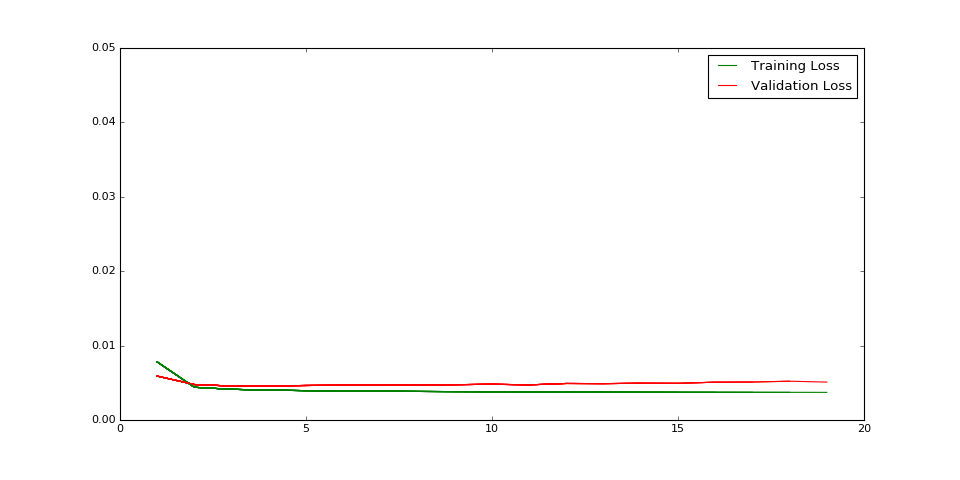

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0078

2017-04-08 04:20:53,157 : INFO : Found lower val loss for epoch 1 => 0.0059


1286325/1286325 [==============================] - 85s - loss: 0.0078 - val_loss: 0.0059
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0044

2017-04-08 04:22:19,815 : INFO : Found lower val loss for epoch 2 => 0.00477


1286325/1286325 [==============================] - 86s - loss: 0.0044 - val_loss: 0.0048
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-08 04:23:45,544 : INFO : Found lower val loss for epoch 3 => 0.00457


1286325/1286325 [==============================] - 85s - loss: 0.0041 - val_loss: 0.0046
Epoch 4/200
1286325/1286325 [==============================] - 85s - loss: 0.0040 - val_loss: 0.0046
Epoch 5/200
1286325/1286325 [==============================] - 84s - loss: 0.0039 - val_loss: 0.0046
Epoch 6/200
1286325/1286325 [==============================] - 84s - loss: 0.0039 - val_loss: 0.0047
Epoch 7/200
1286325/1286325 [==============================] - 85s - loss: 0.0039 - val_loss: 0.0047
Epoch 8/200
1286325/1286325 [==============================] - 84s - loss: 0.0038 - val_loss: 0.0047
Epoch 9/200
1286325/1286325 [==============================] - 85s - loss: 0.0038 - val_loss: 0.0047
Epoch 10/200
1286325/1286325 [==============================] - 84s - loss: 0.0038 - val_loss: 0.0048
Epoch 11/200
1286325/1286325 [==============================] - 87s - loss: 0.0038 - val_loss: 0.0047
Epoch 12/200
1286325/1286325 [==============================] - 83s - loss: 0.0038 - val_loss: 0.0049

2017-04-08 04:47:33,287 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00018: early stopping
CPU times: user 23min 18s, sys: 22min 56s, total: 46min 14s
Wall time: 28min 6s


2017-04-08 04:49:31,684 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 12.544 | Top 3: 0.645 | Top 5: 0.731 | F1 Micro: 0.379 | F1 Macro: 0.040


2017-04-08 04:51:51,293 : INFO : ***************************************************************************************
2017-04-08 04:51:51,308 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           5000500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_32 (Dropout)             (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           250500      dropout_32[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


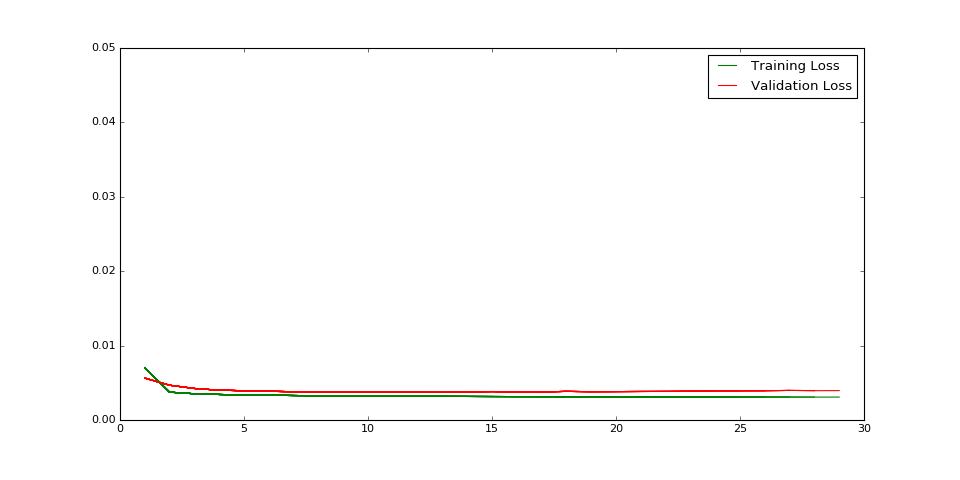

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0070

2017-04-08 04:53:32,413 : INFO : Found lower val loss for epoch 1 => 0.00563


1286325/1286325 [==============================] - 99s - loss: 0.0070 - val_loss: 0.0056
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-08 04:55:07,982 : INFO : Found lower val loss for epoch 2 => 0.00467


1286325/1286325 [==============================] - 95s - loss: 0.0037 - val_loss: 0.0047
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-08 04:57:16,881 : INFO : Found lower val loss for epoch 3 => 0.00424


1286325/1286325 [==============================] - 128s - loss: 0.0035 - val_loss: 0.0042
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-08 04:59:38,768 : INFO : Found lower val loss for epoch 4 => 0.004


1286325/1286325 [==============================] - 141s - loss: 0.0034 - val_loss: 0.0040
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-08 05:01:40,027 : INFO : Found lower val loss for epoch 5 => 0.00394


1286325/1286325 [==============================] - 121s - loss: 0.0034 - val_loss: 0.0039
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 05:03:44,571 : INFO : Found lower val loss for epoch 6 => 0.00386


1286325/1286325 [==============================] - 124s - loss: 0.0033 - val_loss: 0.0039
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 05:05:45,396 : INFO : Found lower val loss for epoch 7 => 0.00381


1286325/1286325 [==============================] - 120s - loss: 0.0033 - val_loss: 0.0038
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 05:07:48,804 : INFO : Found lower val loss for epoch 8 => 0.00378


1286325/1286325 [==============================] - 123s - loss: 0.0033 - val_loss: 0.0038
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 05:09:31,877 : INFO : Found lower val loss for epoch 9 => 0.00377


1286325/1286325 [==============================] - 103s - loss: 0.0032 - val_loss: 0.0038
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 05:12:06,418 : INFO : Found lower val loss for epoch 10 => 0.00376


1286325/1286325 [==============================] - 154s - loss: 0.0032 - val_loss: 0.0038
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 05:13:57,361 : INFO : Found lower val loss for epoch 11 => 0.00374


1286325/1286325 [==============================] - 110s - loss: 0.0032 - val_loss: 0.0037
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 05:16:04,667 : INFO : Found lower val loss for epoch 12 => 0.00373


1286325/1286325 [==============================] - 127s - loss: 0.0032 - val_loss: 0.0037
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 05:17:45,756 : INFO : Found lower val loss for epoch 13 => 0.00371


1286325/1286325 [==============================] - 101s - loss: 0.0032 - val_loss: 0.0037
Epoch 14/200
1286325/1286325 [==============================] - 133s - loss: 0.0032 - val_loss: 0.0038
Epoch 15/200
1286325/1286325 [==============================] - 94s - loss: 0.0032 - val_loss: 0.0038
Epoch 16/200
1286325/1286325 [==============================] - 114s - loss: 0.0031 - val_loss: 0.0037
Epoch 17/200
1286325/1286325 [==============================] - 105s - loss: 0.0031 - val_loss: 0.0038
Epoch 18/200
1286325/1286325 [==============================] - 99s - loss: 0.0031 - val_loss: 0.0038
Epoch 19/200
1286325/1286325 [==============================] - 95s - loss: 0.0031 - val_loss: 0.0038
Epoch 20/200
1286325/1286325 [==============================] - 125s - loss: 0.0031 - val_loss: 0.0038
Epoch 21/200
1286325/1286325 [==============================] - 108s - loss: 0.0031 - val_loss: 0.0038
Epoch 22/200
1286325/1286325 [==============================] - 102s - loss: 0.0031 - val

2017-04-08 05:46:38,864 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00028: early stopping
CPU times: user 36min 28s, sys: 48min 21s, total: 1h 24min 49s
Wall time: 54min 47s


2017-04-08 05:48:55,763 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.253 | Top 3: 0.727 | Top 5: 0.805 | F1 Micro: 0.547 | F1 Macro: 0.145


2017-04-08 05:51:28,595 : INFO : ***************************************************************************************
2017-04-08 05:51:28,598 : INFO : nn_1st-size_500_1st-act_sigmoid_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           5000500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 500)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 2000)          1002000     dropout_33[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


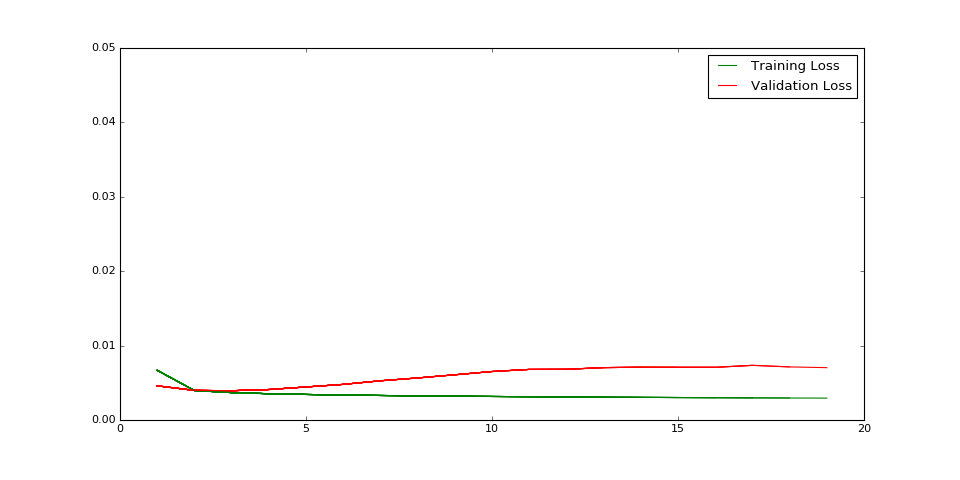

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0067

2017-04-08 05:53:02,212 : INFO : Found lower val loss for epoch 1 => 0.00459


1286325/1286325 [==============================] - 91s - loss: 0.0067 - val_loss: 0.0046
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-08 05:54:44,825 : INFO : Found lower val loss for epoch 2 => 0.00398


1286325/1286325 [==============================] - 102s - loss: 0.0040 - val_loss: 0.0040
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-08 05:56:12,427 : INFO : Found lower val loss for epoch 3 => 0.00394


1286325/1286325 [==============================] - 87s - loss: 0.0037 - val_loss: 0.0039
Epoch 4/200
1286325/1286325 [==============================] - 97s - loss: 0.0035 - val_loss: 0.0041
Epoch 5/200
1286325/1286325 [==============================] - 104s - loss: 0.0034 - val_loss: 0.0044
Epoch 6/200
1286325/1286325 [==============================] - 104s - loss: 0.0034 - val_loss: 0.0048
Epoch 7/200
1286325/1286325 [==============================] - 87s - loss: 0.0033 - val_loss: 0.0053
Epoch 8/200
1286325/1286325 [==============================] - 87s - loss: 0.0032 - val_loss: 0.0057
Epoch 9/200
1286325/1286325 [==============================] - 87s - loss: 0.0032 - val_loss: 0.0061
Epoch 10/200
1286325/1286325 [==============================] - 92s - loss: 0.0032 - val_loss: 0.0065
Epoch 11/200
1286325/1286325 [==============================] - 97s - loss: 0.0031 - val_loss: 0.0068
Epoch 12/200
1286325/1286325 [==============================] - 91s - loss: 0.0031 - val_loss: 0.00

2017-04-08 06:21:14,040 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00018: early stopping
CPU times: user 24min 9s, sys: 25min 40s, total: 49min 49s
Wall time: 29min 44s


2017-04-08 06:22:32,259 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.910 | Top 3: 0.688 | Top 5: 0.771 | F1 Micro: 0.462 | F1 Macro: 0.066


2017-04-08 06:24:55,401 : INFO : ***************************************************************************************
2017-04-08 06:24:55,406 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_34 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          1001000     dropout_34[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


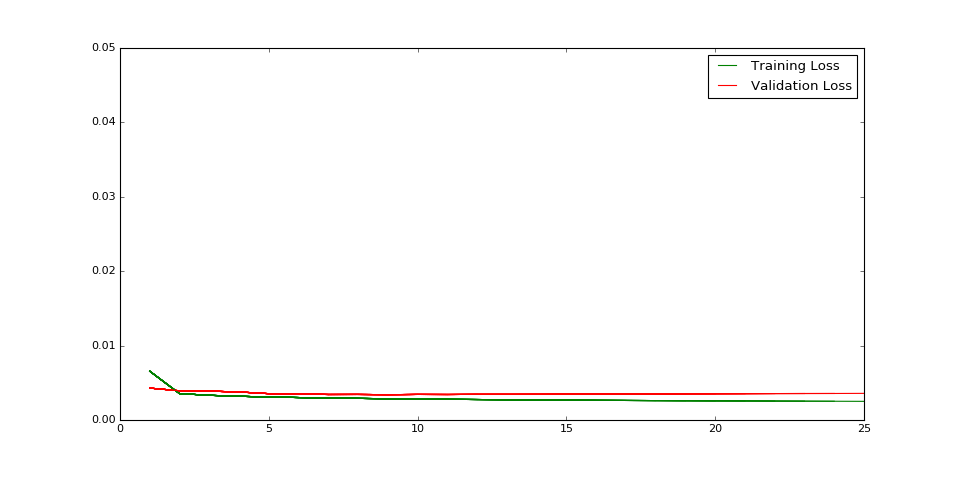

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0066

2017-04-08 06:27:26,819 : INFO : Found lower val loss for epoch 1 => 0.00429


1286325/1286325 [==============================] - 149s - loss: 0.0066 - val_loss: 0.0043
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-08 06:29:51,764 : INFO : Found lower val loss for epoch 2 => 0.00393


1286325/1286325 [==============================] - 144s - loss: 0.0035 - val_loss: 0.0039
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 06:31:38,868 : INFO : Found lower val loss for epoch 3 => 0.00388


1286325/1286325 [==============================] - 107s - loss: 0.0033 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-08 06:33:31,129 : INFO : Found lower val loss for epoch 4 => 0.00377


1286325/1286325 [==============================] - 112s - loss: 0.0032 - val_loss: 0.0038
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0031

2017-04-08 06:35:38,008 : INFO : Found lower val loss for epoch 5 => 0.00354


1286325/1286325 [==============================] - 126s - loss: 0.0031 - val_loss: 0.0035
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0030

2017-04-08 06:37:34,201 : INFO : Found lower val loss for epoch 6 => 0.00349


1286325/1286325 [==============================] - 116s - loss: 0.0030 - val_loss: 0.0035
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0030

2017-04-08 06:39:10,204 : INFO : Found lower val loss for epoch 7 => 0.00343


1286325/1286325 [==============================] - 95s - loss: 0.0030 - val_loss: 0.0034
Epoch 8/200
1286325/1286325 [==============================] - 96s - loss: 0.0029 - val_loss: 0.0034
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0029

2017-04-08 06:42:24,742 : INFO : Found lower val loss for epoch 9 => 0.00341


1286325/1286325 [==============================] - 98s - loss: 0.0029 - val_loss: 0.0034
Epoch 10/200
1286325/1286325 [==============================] - 107s - loss: 0.0028 - val_loss: 0.0034
Epoch 11/200
1286325/1286325 [==============================] - 123s - loss: 0.0028 - val_loss: 0.0034
Epoch 12/200
1286325/1286325 [==============================] - 114s - loss: 0.0028 - val_loss: 0.0034
Epoch 13/200
1286325/1286325 [==============================] - 109s - loss: 0.0027 - val_loss: 0.0034
Epoch 14/200
1286325/1286325 [==============================] - 146s - loss: 0.0027 - val_loss: 0.0035
Epoch 15/200
1286325/1286325 [==============================] - 126s - loss: 0.0027 - val_loss: 0.0035
Epoch 16/200
1286325/1286325 [==============================] - 122s - loss: 0.0026 - val_loss: 0.0035
Epoch 17/200
1286325/1286325 [==============================] - 103s - loss: 0.0026 - val_loss: 0.0035
Epoch 18/200
1286325/1286325 [==============================] - 112s - loss: 0.0026 - v

2017-04-08 07:19:21,562 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00024: early stopping
CPU times: user 33min 46s, sys: 50min 24s, total: 1h 24min 11s
Wall time: 54min 25s


2017-04-08 07:21:19,626 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 7.247 | Top 3: 0.743 | Top 5: 0.821 | F1 Micro: 0.565 | F1 Macro: 0.182


2017-04-08 07:23:44,315 : INFO : ***************************************************************************************
2017-04-08 07:23:44,319 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_35 (Dropout)             (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_35[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


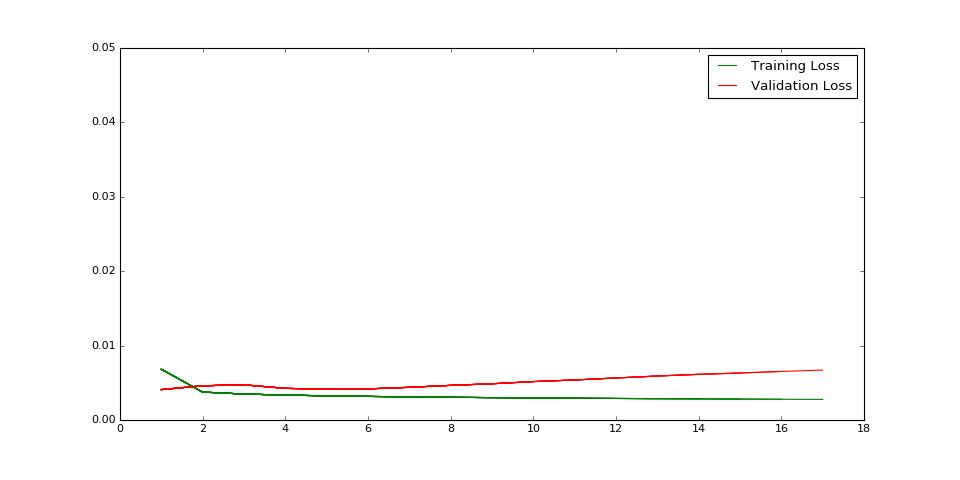

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0068

2017-04-08 07:30:11,680 : INFO : Found lower val loss for epoch 1 => 0.00409


1286325/1286325 [==============================] - 385s - loss: 0.0068 - val_loss: 0.0041
Epoch 2/200
1286325/1286325 [==============================] - 424s - loss: 0.0038 - val_loss: 0.0046
Epoch 3/200
1286325/1286325 [==============================] - 451s - loss: 0.0035 - val_loss: 0.0047
Epoch 4/200
1286325/1286325 [==============================] - 431s - loss: 0.0033 - val_loss: 0.0043
Epoch 5/200
1286325/1286325 [==============================] - 315s - loss: 0.0032 - val_loss: 0.0042
Epoch 6/200
1286325/1286325 [==============================] - 103s - loss: 0.0032 - val_loss: 0.0042
Epoch 7/200
1286325/1286325 [==============================] - 95s - loss: 0.0031 - val_loss: 0.0044
Epoch 8/200
1286325/1286325 [==============================] - 97s - loss: 0.0031 - val_loss: 0.0047
Epoch 9/200
1286325/1286325 [==============================] - 90s - loss: 0.0030 - val_loss: 0.0049
Epoch 10/200
1286325/1286325 [==============================] - 90s - loss: 0.0030 - val_loss: 0.

2017-04-08 08:17:01,948 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00016: early stopping
CPU times: user 23min 49s, sys: 50min 17s, total: 1h 14min 7s
Wall time: 53min 17s


2017-04-08 08:18:21,927 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.145 | Top 3: 0.668 | Top 5: 0.753 | F1 Micro: 0.429 | F1 Macro: 0.051


2017-04-08 08:20:44,887 : INFO : ***************************************************************************************
2017-04-08 08:20:44,890 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_36 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_36[0][0]                 
Total params: 10941940
____________________________________________________________________

<IPython.core.display.Javascript object>


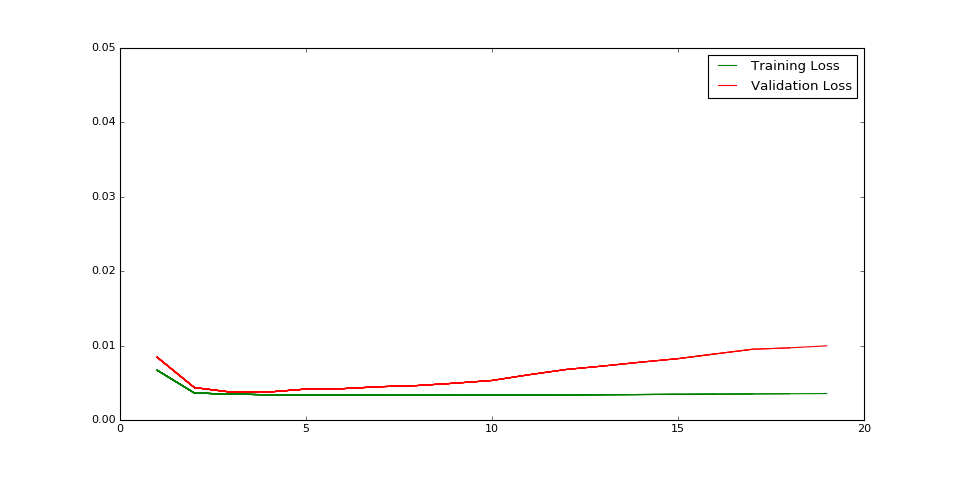

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0067

2017-04-08 08:22:47,971 : INFO : Found lower val loss for epoch 1 => 0.00843


1286325/1286325 [==============================] - 121s - loss: 0.0067 - val_loss: 0.0084
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-08 08:24:18,446 : INFO : Found lower val loss for epoch 2 => 0.00436


1286325/1286325 [==============================] - 90s - loss: 0.0036 - val_loss: 0.0044
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-08 08:25:48,888 : INFO : Found lower val loss for epoch 3 => 0.00374


1286325/1286325 [==============================] - 90s - loss: 0.0035 - val_loss: 0.0037
Epoch 4/200
1286325/1286325 [==============================] - 87s - loss: 0.0034 - val_loss: 0.0038
Epoch 5/200
1286325/1286325 [==============================] - 89s - loss: 0.0034 - val_loss: 0.0042
Epoch 6/200
1286325/1286325 [==============================] - 85s - loss: 0.0033 - val_loss: 0.0042
Epoch 7/200
1286325/1286325 [==============================] - 89s - loss: 0.0033 - val_loss: 0.0045
Epoch 8/200
1286325/1286325 [==============================] - 88s - loss: 0.0033 - val_loss: 0.0046
Epoch 9/200
1286325/1286325 [==============================] - 90s - loss: 0.0033 - val_loss: 0.0049
Epoch 10/200
1286325/1286325 [==============================] - 89s - loss: 0.0033 - val_loss: 0.0053
Epoch 11/200
1286325/1286325 [==============================] - 89s - loss: 0.0034 - val_loss: 0.0061
Epoch 12/200
1286325/1286325 [==============================] - 87s - loss: 0.0034 - val_loss: 0.0068

2017-04-08 08:50:02,812 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00018: early stopping
CPU times: user 24min 42s, sys: 24min 59s, total: 49min 42s
Wall time: 29min 17s


2017-04-08 08:51:54,845 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.259 | Top 3: 0.734 | Top 5: 0.812 | F1 Micro: 0.469 | F1 Macro: 0.097


2017-04-08 08:54:18,774 : INFO : ***************************************************************************************
2017-04-08 08:54:18,777 : INFO : nn_1st-size_1000_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_37 (Dropout)             (None, 1000)          0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           500500      dropout_37[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


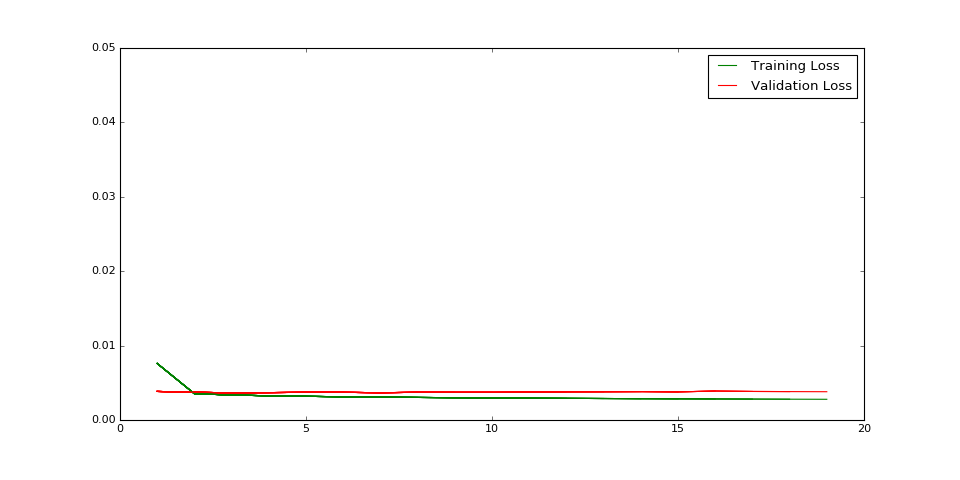

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0076

2017-04-08 08:56:17,424 : INFO : Found lower val loss for epoch 1 => 0.00384


1286325/1286325 [==============================] - 116s - loss: 0.0076 - val_loss: 0.0038
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-08 08:58:02,787 : INFO : Found lower val loss for epoch 2 => 0.00373


1286325/1286325 [==============================] - 105s - loss: 0.0035 - val_loss: 0.0037
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-08 08:59:42,487 : INFO : Found lower val loss for epoch 3 => 0.00365


1286325/1286325 [==============================] - 99s - loss: 0.0034 - val_loss: 0.0036
Epoch 4/200
1286325/1286325 [==============================] - 107s - loss: 0.0033 - val_loss: 0.0037
Epoch 5/200
1286325/1286325 [==============================] - 97s - loss: 0.0032 - val_loss: 0.0037
Epoch 6/200
1286325/1286325 [==============================] - 110s - loss: 0.0031 - val_loss: 0.0037
Epoch 7/200
1286325/1286325 [==============================] - 93s - loss: 0.0031 - val_loss: 0.0037
Epoch 8/200
1286325/1286325 [==============================] - 91s - loss: 0.0030 - val_loss: 0.0037
Epoch 9/200
1286325/1286325 [==============================] - 93s - loss: 0.0030 - val_loss: 0.0037
Epoch 10/200
1286325/1286325 [==============================] - 89s - loss: 0.0030 - val_loss: 0.0037
Epoch 11/200
1286325/1286325 [==============================] - 88s - loss: 0.0029 - val_loss: 0.0038
Epoch 12/200
1286325/1286325 [==============================] - 90s - loss: 0.0029 - val_loss: 0.00

2017-04-08 09:24:41,452 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00018: early stopping
CPU times: user 25min 22s, sys: 26min 13s, total: 51min 35s
Wall time: 30min 22s


2017-04-08 09:25:50,610 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 8.203 | Top 3: 0.720 | Top 5: 0.800 | F1 Micro: 0.516 | F1 Macro: 0.123


2017-04-08 09:28:10,445 : INFO : ***************************************************************************************
2017-04-08 09:28:10,449 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           5000500     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_38 (Dropout)             (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 2000)          1002000     dropout_38[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


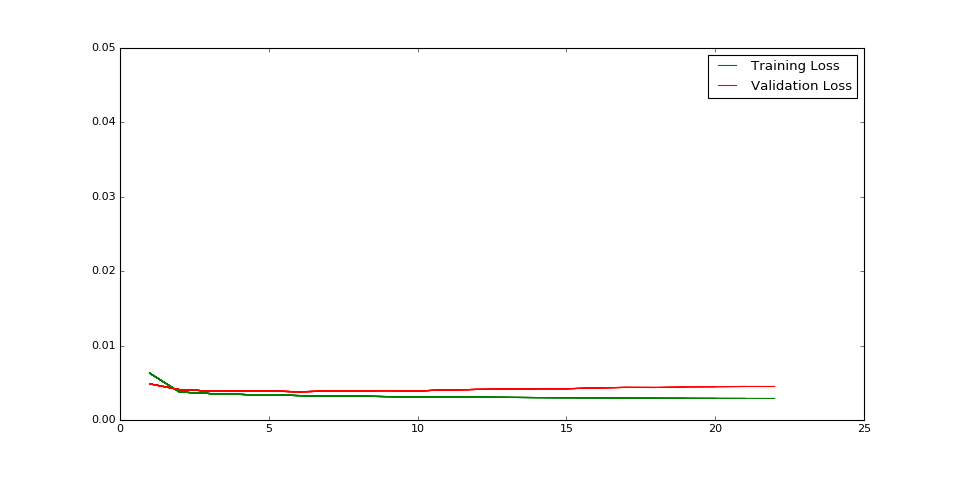

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0063

2017-04-08 09:29:49,959 : INFO : Found lower val loss for epoch 1 => 0.00486


1286325/1286325 [==============================] - 84s - loss: 0.0063 - val_loss: 0.0049
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-08 09:31:16,856 : INFO : Found lower val loss for epoch 2 => 0.00409


1286325/1286325 [==============================] - 86s - loss: 0.0038 - val_loss: 0.0041
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-08 09:32:42,184 : INFO : Found lower val loss for epoch 3 => 0.0039


1286325/1286325 [==============================] - 85s - loss: 0.0036 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-08 09:34:08,227 : INFO : Found lower val loss for epoch 4 => 0.00385


1286325/1286325 [==============================] - 86s - loss: 0.0034 - val_loss: 0.0038
Epoch 5/200
1286325/1286325 [==============================] - 112s - loss: 0.0034 - val_loss: 0.0039
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-08 09:38:09,989 : INFO : Found lower val loss for epoch 6 => 0.0038


1286325/1286325 [==============================] - 129s - loss: 0.0033 - val_loss: 0.0038
Epoch 7/200
1286325/1286325 [==============================] - 97s - loss: 0.0032 - val_loss: 0.0039
Epoch 8/200
1286325/1286325 [==============================] - 120s - loss: 0.0032 - val_loss: 0.0039
Epoch 9/200
1286325/1286325 [==============================] - 100s - loss: 0.0031 - val_loss: 0.0040
Epoch 10/200
1286325/1286325 [==============================] - 126s - loss: 0.0031 - val_loss: 0.0039
Epoch 11/200
1286325/1286325 [==============================] - 88s - loss: 0.0031 - val_loss: 0.0040
Epoch 12/200
1286325/1286325 [==============================] - 83s - loss: 0.0031 - val_loss: 0.0041
Epoch 13/200
1286325/1286325 [==============================] - 81s - loss: 0.0030 - val_loss: 0.0041
Epoch 14/200
1286325/1286325 [==============================] - 82s - loss: 0.0030 - val_loss: 0.0042
Epoch 15/200
1286325/1286325 [==============================] - 83s - loss: 0.0030 - val_loss:

2017-04-08 10:04:31,908 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00021: early stopping
CPU times: user 27min 20s, sys: 30min 9s, total: 57min 29s
Wall time: 36min 7s


2017-04-08 10:06:11,584 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.201 | Top 3: 0.696 | Top 5: 0.782 | F1 Micro: 0.512 | F1 Macro: 0.141
CPU times: user 10h 37min 9s, sys: 12h 13min 20s, total: 22h 50min 30s
Wall time: 15h 12min 46s


In [32]:
%%time
data_types = ["bm25"]
# data_types = ["tf"]
for data_type in data_types:
    info("=============== {} Being Evaluated ================".format(data_type))
    
    GLOBAL_VARS.MODEL_NAME = data_type + "/size_{}".format(MAX_TERMS)
     
    data_training_location = exports_location + "{}_training_sparse_data.pkl".format(data_type)
    data_training_docids_location = exports_location + "{}_training_sparse_docids.pkl".format(data_type)
    data_validation_location = exports_location + "{}_validation_sparse_data.pkl".format(data_type)
    data_validation_docids_location = exports_location + "{}_validation_sparse_docids.pkl".format(data_type)
    
    # Get the training data
    info('Getting Training Data')
    %time X = pickle.load(open(data_training_location, "r"))
    training_data_docids = pickle.load(open(data_training_docids_location, "r"))
    %time y = get_label_data(classifications, training_data_docids, doc_classification_map)
    
    print X.shape
    print y.shape

    # Get the validation data
    info('Getting Validation Data')
    %time Xv = pickle.load(open(data_validation_location,'r'))
    validation_data_docids = pickle.load(open(data_validation_docids_location, "r"))
    %time yv = get_label_data(classifications, validation_data_docids, doc_classification_map)
    
    NN_INPUT_NEURONS = X.shape[1]


    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options,
        'second_hidden_dropout':second_hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

    param_results_dict = {}

    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))

    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results in {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    for parameters in param_sampler:
        start_time = time.time()
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        second_hidden_dropout_do = parameters['second_hidden_dropout']

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )
        if second_hidden_dropout_do:
            GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

        if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
            print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
            continue
    #         if first_hidden_layer_size < DOC2VEC_SIZE or second_hidden_layer_size < NN_OUTPUT_NEURONS:
    #             print "skipping: {} due to 1st layer size {} < {} or 2nd layer size {} < {}".format(GLOBAL_VARS.NN_MODEL_NAME,
    #                                                                                                 first_hidden_layer_size, DOC2VEC_SIZE, 
    #                                                                                                 second_hidden_layer_size, NN_OUTPUT_NEURONS)
    #             continue


        info('***************************************************************************************')
        info(GLOBAL_VARS.NN_MODEL_NAME)

        model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
        model.summary()

        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                      patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
        metrics_callback = MetricsCallbackWithGenerator()

        # Model Fitting
#         %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
#                                   nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, callbacks=[early_stopper, metrics_callback])

        %time history = model.fit_generator(generator=nn_batch_generator(X, y, NN_BATCH_SIZE), \
                                            samples_per_epoch=X.shape[0],\
                                            validation_data=nn_batch_generator(Xv, yv, NN_BATCH_SIZE),\
                                            nb_val_samples=Xv.shape[0],\
                                            nb_epoch=NN_MAX_EPOCHS, callbacks=[early_stopper, metrics_callback])

        # using the recorded weights of the best recorded validation loss
        last_model_weights = model.get_weights()
        info('Evaluating on Validation Data using saved best weights')
        model.set_weights(metrics_callback.best_weights)
        yvp = model.predict_generator(generator=nn_batch_generator(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
            validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'])
        best_validation_metrics = validation_metrics
        time.sleep(0.2)

        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

        duration = time.time() - start_time
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

        del history, last_model_weights, metrics_callback

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))
    #del X, Xv

In [24]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))


## Testing

In [52]:
data_type = 'bm25'

In [62]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [63]:
NN_BATCH_SIZE = 2048

In [64]:
data_test_location = exports_location + "{}_test_sparse_data.pkl".format(data_type)
data_test_docids_location = exports_location + "{}_test_sparse_docids.pkl".format(data_type)

TEST_METRICS_FILENAME = '{}_batch_{}_test_metrics.pkl'.format(classifications_type, NN_BATCH_SIZE)
GLOBAL_VARS.MODEL_NAME = data_type + "/size_{}".format(MAX_TERMS)

In [65]:
param_results_dict = pickle.load(open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))))

In [66]:
len(param_results_dict)

19

In [67]:
# Get the test data
info('Getting Test Data')
%time Xt = pickle.load(open(data_test_location, "r"))
test_data_docids = pickle.load(open(data_test_docids_location, "r"))
%time yt = get_label_data(classifications, test_data_docids, doc_classification_map)

print Xt.shape
print yt.shape

2017-04-08 17:45:12,190 : INFO : Getting Test Data


CPU times: user 2min 30s, sys: 17.8 s, total: 2min 48s
Wall time: 2min 48s
CPU times: user 16.4 s, sys: 320 ms, total: 16.7 s
Wall time: 16.5 s
(401877, 10000)
(401877, 940)


In [68]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [69]:
first_hidden_layer_size = 1000
first_hidden_layer_activation = 'relu'
second_hidden_layer_size = 1000
second_hidden_layer_activation = 'sigmoid'
input_dropout_do = False
hidden_dropout_do = True

#     print "===================================================================================\n" + \
#           "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
#           "Input Dropout: {}, Hidden Dropout: {} \n" + \
#           "==========================".format(first_hidden_layer_size, first_hidden_layer_activation, 
#                                                 second_hidden_layer_size, second_hidden_layer_activation, 
#                                                 input_dropout_do, hidden_dropout_do)

GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
    first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
    second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
)
if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                              first_hidden_layer_size, first_hidden_layer_activation, 
                              second_hidden_layer_size, second_hidden_layer_activation, 
                              input_dropout_do, hidden_dropout_do)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

time.sleep(0.2)
info('Evaluating on Test Data using best weights')
ytp = model.predict_generator(generator=nn_batch_generator(Xt, yt, NN_BATCH_SIZE), val_samples=Xt.shape[0])
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

    
ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                TEST_METRICS_FILENAME), 'w'))


2017-04-08 17:48:17,750 : INFO : ***************************************************************************************
2017-04-08 17:48:17,751 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 10000)         0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          10001000    doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_43 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          1001000     dropout_43[0][0]                 
___________________________________________________________________________________________

2017-04-08 17:48:18,310 : INFO : Evaluating on Test Data using best weights
2017-04-08 17:52:08,168 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 7.096, Avg Labels: 1.340, 
		 Top 1: 0.618, Top 3: 0.753, Top 5: 0.830, 
		 F1 Micro: 0.567, F1 Macro: 0.168, Total Pos: 343,020
